In [111]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.ensemble import IsolationForest

In [120]:
train = pd.read_parquet('../data/BTS/train.parquet')
test = pd.read_parquet('../data/BTS/test.parquet')

In [122]:
dataset = pd.concat([train, test])

In [167]:
dataset[dataset['ZTFID']=='ZTF19abanmqt']['jd'].to_numpy()[0]

array([2458658.6905556, 2458995.6991435, 2459182.0512847, 2459196.0430903,
       2459199.0414931, 2459204.9687616, 2459205.0208565, 2459217.0064236,
       2459217.0347569, 2459218.977963 , 2459218.9972222, 2459224.043206 ,
       2459225.9622106, 2459227.982338 , 2459231.9426273, 2459231.999919 ,
       2459251.9208333, 2459251.9786458, 2459253.88375  , 2459253.985625 ,
       2459255.8947569, 2459255.919838 , 2459258.8784375, 2459262.8733218,
       2459264.9139005, 2459265.0118634, 2459266.8785417, 2459268.8740394,
       2459278.8334375, 2459278.9212269, 2459290.857037 , 2459292.8314815,
       2459294.7701852, 2459307.8140856, 2459307.8403935, 2459309.7915972,
       2459313.7570602, 2459317.817419 , 2459321.8124074, 2459323.7731944,
       2459323.831088 , 2459325.8159144, 2459334.7311458, 2459336.776875 ,
       2459338.7956366, 2459340.7739815, 2459340.836875 , 2459342.7736574,
       2459342.8337269, 2459344.7312616, 2459344.7529977, 2459346.7952083,
       2459346.8736921, 2

In [219]:
def plot_ztf_data(ztfid):

    ztf_fid_to_filter = {
        1: 'g',
        2: 'r', 
        3: 'i' 
    }

    ZTF_fid_to_color = {
        'r': np.array((255, 0, 0))/255,
        'g': np.array((0, 255, 0))/255,
        'i': np.array((0, 0, 255))/255,
    }

    im_shape = (63, 63)
    
    row = dataset[dataset['ZTFID']==ztfid]
    
    bts_class = row['bts_class'].to_numpy()[0]
    mag = row['magpsf'].to_numpy()[0]
    mag_unc = row['sigmapsf'].to_numpy()[0]
    time = row['jd'].to_numpy()[0] - min(row['jd'].to_numpy()[0])
    filt = np.array([ztf_fid_to_filter[k] for k in row['fid'].to_numpy()[0]])

    imgs = {
        'g': np.reshape(row['g_reference'].to_numpy()[0], im_shape) if isinstance(row['g_reference'].to_numpy()[0], np.ndarray) else np.zeros(im_shape), 
        'r': np.reshape(row['r_reference'].to_numpy()[0], im_shape) if isinstance(row['r_reference'].to_numpy()[0], np.ndarray) else np.zeros(im_shape),
        'i': np.reshape(row['i_reference'].to_numpy()[0], im_shape) if isinstance(row['i_reference'].to_numpy()[0], np.ndarray) else np.zeros(im_shape), 
    }
    


    fig = plt.figure(figsize=(12, 6))
    gs = fig.add_gridspec(2, 3, height_ratios=[1, 1], hspace=0.3, wspace=0.2)
    
    # Top row: light curve across all columns
    ax_lc = fig.add_subplot(gs[0, :])
    for f in np.unique(filt):
        idx = np.where(filt==f)[0]
        ax_lc.errorbar(time[idx], mag[idx], yerr=mag_unc[idx], fmt='o', label=f, color=ZTF_fid_to_color[f])
    plt.legend()
    ax_lc.set_xlabel('Time (days)')
    ax_lc.set_ylabel('mag')
    ax_lc.invert_yaxis()
    
    ax_lc.set_title(f"{ztfid}: {bts_class}")
    
    # Bottom row: three filter images
    for i, f in enumerate(['g', 'r', 'i']):
        ax = fig.add_subplot(gs[1, i])
        im = ax.imshow(imgs[f], origin='lower', cmap='viridis')
        ax.set_title(f)
        ax.axis('off')
        # Optional colorbar:
        # fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

/var/folders/t6/gdw9ytlx48nd402t7_62k3r00000gn/T/ipykernel_24377/3691243767.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


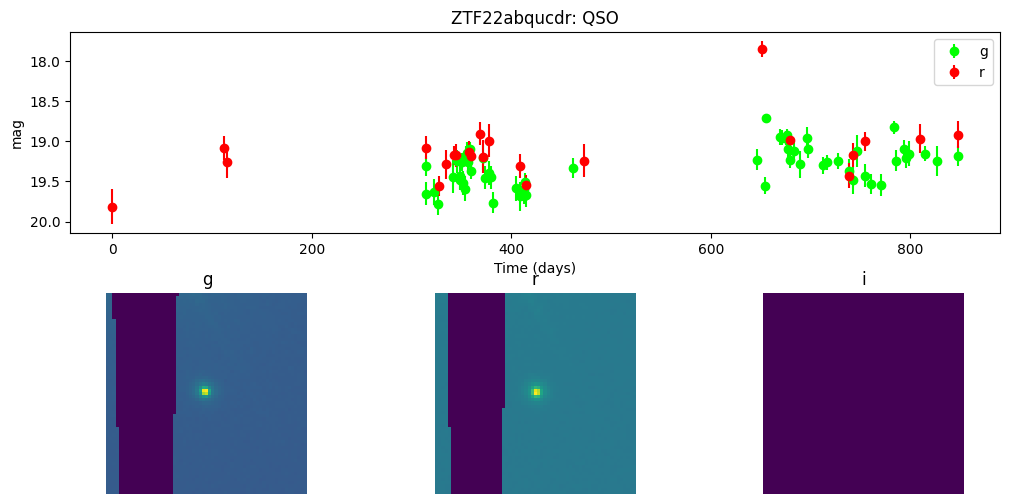

In [221]:
plot_ztf_data('ZTF22abqucdr')

In [112]:
normal_classes = ['SN-Ia','SN-Ib/c','SN-II','SLSN-I','CV','AGN']

In [113]:
model_dir = "../models/BTS_MM/rosy-moon-43/"

In [114]:
final_embeddings = pd.read_csv(f"{model_dir}/embeddings/trigger+1024.csv")

In [115]:
if_dict = {}
for c in normal_classes:
    class_embeddings = final_embeddings[final_embeddings['class']==c].to_numpy()[:,:64]
    if_dict[c] = IsolationForest(random_state=0).fit(class_embeddings)

In [116]:
scores = []
for i in range(len(final_embeddings)):
    class_scores = []
    for c in normal_classes:
        class_scores.append(if_dict[c].decision_function(final_embeddings.to_numpy()[i,:64].reshape(1, -1))[0])
    scores.append(min(class_scores))

In [117]:
final_embeddings['a_score'] = scores

In [128]:
final_embeddings.sort_values(by='a_score', ascending=False)[['a_score','bts_class','ztf_ids']].head(n=50)

,a_score,bts_class,ztf_ids
768,-0.000515,AGN,ZTF19abanmqt
714,-0.002481,QSO,ZTF22abqucdr
4,-0.004566,AGN,ZTF21aatlewl
1233,-0.004602,AGN,ZTF18acayrgz
1087,-0.005093,FBOT,ZTF24aaxhxhf
381,-0.005592,AGN,ZTF20ablkoym
1196,-0.006437,CV,ZTF18aawjxgs
795,-0.006584,AGN,ZTF19accczao
996,-0.007163,TDE,ZTF17aaazdba
215,-0.007573,AGN,ZTF18acahbqb


AGN -0.01616355100459932
AGN? -0.10034273894993423
AM CVn -0.119939911417626
CLAGN -0.015083080069488775
CV -0.21134509151234776
CV? -0.21101094343989585
Ca-rich -0.16222233168217737
FBOT -0.13806096101003013
ILRT -0.16656647993859341
Ien -0.16056123017706658
LBV -0.1619330403569862
LINER -0.02168440496566082
LRN -0.12013967210307963
QSO -0.01444276573889336
SLSN-I -0.1503010354805756
SLSN-I? -0.17060703947248101
SLSN-II -0.17111884046862652
SN II -0.1789401854976037
SN II-SL -0.1386439959216218
SN II-norm -0.09450033476540276
SN II-pec -0.1883679695246559
SN II? -0.20072665368258397
SN IIP -0.06869780658218172
SN IIb -0.2072375409333851
SN IIb-pec -0.12658049689366668
SN IIn -0.17505377342680806
SN IIn? -0.018703776208577994
SN Ia -0.22961145861731935
SN Ia-00cx -0.24818520199731509
SN Ia-03fg -0.21301878935023177
SN Ia-91T -0.2312631144689224
SN Ia-91bg -0.1892636358316775
SN Ia-91bg? -0.08825065077410199
SN Ia-CSM -0.15389940745728914
SN Ia-CSM? -0.09915698398231526
SN Ia-norm -0.21

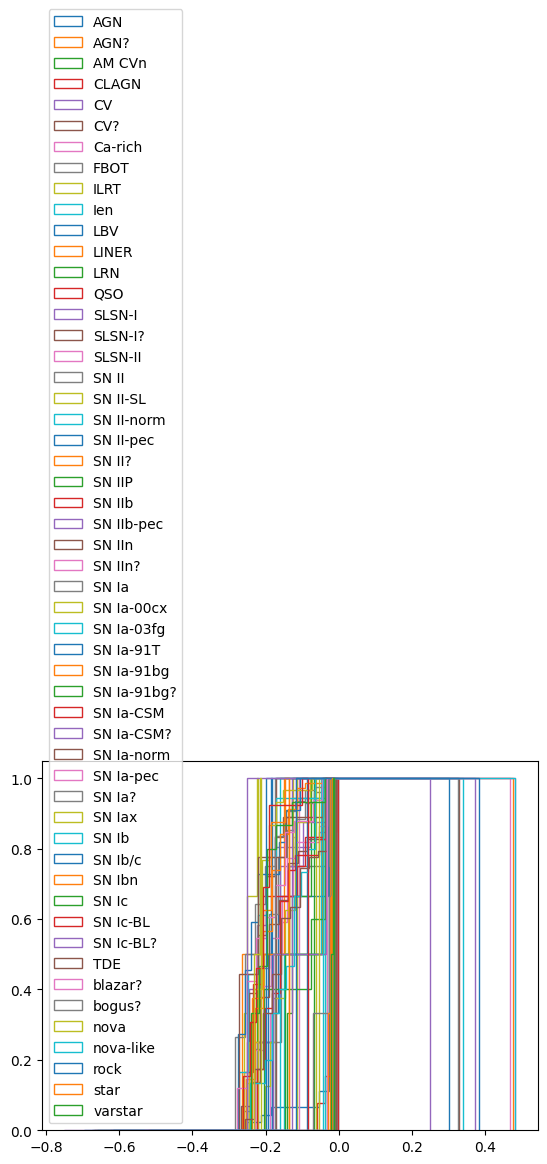

In [95]:
for c in np.unique(final_embeddings['bts_class'].to_list()):
    class_df = final_embeddings[final_embeddings['bts_class']==c]
    print(c, np.median(class_df['a_score']))
    #sns.kdeplot(class_df, x='a_score', label=c)
    plt.hist(class_df['a_score'].to_list(), density=True, label=c, cumulative=True, histtype='step')
    #plt.xlim(min(class_df['a_score'].to_list()), max(class_df['a_score'].to_list()))
    #plt.show()
plt.legend()
#plt.show()